# Create simple NN model to classify car's images

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [15]:
from torchvision.transforms import ToTensor, Lambda, Compose, ConvertImageDtype, Normalize
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

## Create custom datatset

In [20]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations, img_dir, target, path, 
                 train=True, transform=None, target_transform=None, task='class'):
        if train:
            flag = 'train'
        else:
            flag = 'test'
        data = pd.read_pickle(annotations).query('train == @flag')
        self.img_paths = list(data[path])
        self.img_labels = list(data[target])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.class_labels = None
        if task == 'class':
            self.class_labels = dict(zip(data[target], data['producer']))
        
    def __len__(self):
        return len(self.img_labels)
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = read_image(img_path)
        label = self.img_labels[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label
    
    def get_class_labels(self):
        return self.class_labels

## Create simple NN

In [69]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(16*58*78, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 12)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [93]:
transf = Compose([ConvertImageDtype(torch.float),
                  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                 ])

train = CustomImageDataset('../../data/1_automarket_exploration/source_data/labels.pckl',
                           '../../data/1_automarket_exploration/auto_img/',
                           'producer_code',
                           'path',
                           train=True,
                           transform = transf,
                           target_transform = Lambda(lambda y: torch.zeros(
                               12, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
                           )
train_dataloader = DataLoader(train, batch_size=128, shuffle=True)

test = CustomImageDataset('../../data/1_automarket_exploration/source_data/labels.pckl',
                           '../../data/1_automarket_exploration/auto_img/',
                           'producer_code',
                           'path',
                           train=False,
                           transform = transf,
                           target_transform = Lambda(lambda y: torch.zeros(
                               12, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
                           )
test_dataloader = DataLoader(test, batch_size=128, shuffle=True)

In [89]:
classes = train.get_class_labels()
classes

{0: 'BMW',
 1: 'Chevrolet',
 2: 'Ford',
 3: 'Hyundai',
 4: 'Kia',
 5: 'LADA',
 6: 'Mercedes-Benz',
 7: 'Mitsubishi',
 8: 'Nissan',
 9: 'Renault',
 10: 'Toyota',
 11: 'Volkswagen'}

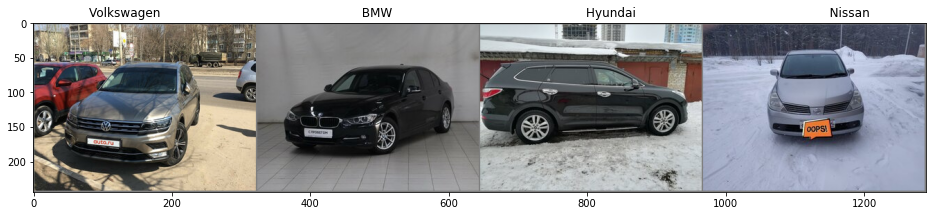

In [90]:
def imshow(img, labels):
    plt.figure(figsize=(16,4))
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title((' '*50).join('%5s' % classes[int(labels[j].argmax())] for j in range(4)))
    plt.show()


dataiter = iter(train_dataloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images), labels)



In [91]:
images[0].shape

torch.Size([3, 240, 320])

In [94]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

net = LeNet().to(device)
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

Using cuda device
LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=72384, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=12, bias=True)
)


## Train

In [95]:
for epoch in range(2):
    running_loss = 0.0
    for i, (images, labels) in tqdm(enumerate(train_dataloader, 0)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels.argmax(axis=1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print('Finished training')


KeyboardInterrupt: 

## Test

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

## Save model

In [ ]:
torch.save(net.state_dict(), "model.pth")

## TODO:
1. Try different net achitectures
2. Add interpretation of models
3. Implement production model usage